In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.signal import periodogram, correlate, signaltools
import scipy.spatial.distance as sp_distance
from scipy.optimize import curve_fit
import math
import seaborn as sns
import pandas as pd
import hypertools as hyp
from numpy.fft import fft, rfft, rfftfreq
from IPython.display import HTML
import os
import pickle
import time
from os.path import join as pjoin

from brainiak.funcalign.rsrm import RSRM
from brainiak.funcalign.srm import SRM
from nilearn.image import load_img
from nilearn.masking import apply_mask
%matplotlib inline

/data/BnB_USER/oliver/somato/raw/venvs/somato_env/lib/python3.5/site-packages/hypertools/plot/__init__.py:10: UserWarning: Could not switch backend to TkAgg.  This may impact performance of the plotting functions.
  warnings.warn('Could not switch backend to TkAgg.  This may impact performance of the plotting functions.')
/data/BnB_USER/oliver/somato/raw/venvs/somato_env/lib/python3.5/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
# import io functions from my srm script
import runpy
file_globals = runpy.run_path('/data/BnB_USER/oliver/somato/raw/code/srm/srm_roi.py')
datagrabber = file_globals['datagrabber']
load_data = file_globals['load_data']
grab_subject_ids = file_globals['grab_subject_ids']

In [3]:
sns.set_context('notebook')
sns.set()
sns.set_style('whitegrid')

In [4]:
# load rsrm results based on cluster-selected features

srm_pickle_path = '/home/homeGlobal/oli/somato/scratch/srm_roi/rsrm.p'
with open(srm_pickle_path, 'rb') as f:
    srm = pickle.load(f)

# Number of voxels in ROI per subject

Text(0.5, 1.0, 'number of voxels in ROI per subject')

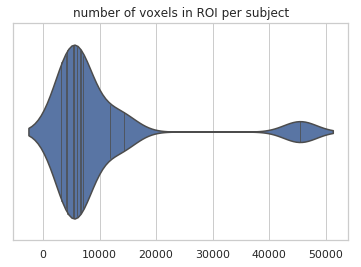

In [5]:
n_vox_persub = [srm.w_[i].shape[0] for i in range(len(srm.w_))]
sns.violinplot(n_vox_persub, inner="stick", bw=.25)
plt.title('number of voxels in ROI per subject')

One outlier (subject with index 8) has n ~ 45,000 voxels in its ROI. After inspecting the mask volume, it seems that it has many "stray" clusters, which led to a stronger scaling of n through the dilation procedure. Furthermore, the most dorsal slices of that subject are almost completely included in the ROI, presumably because of some artifact.

# Shared responses heatmap

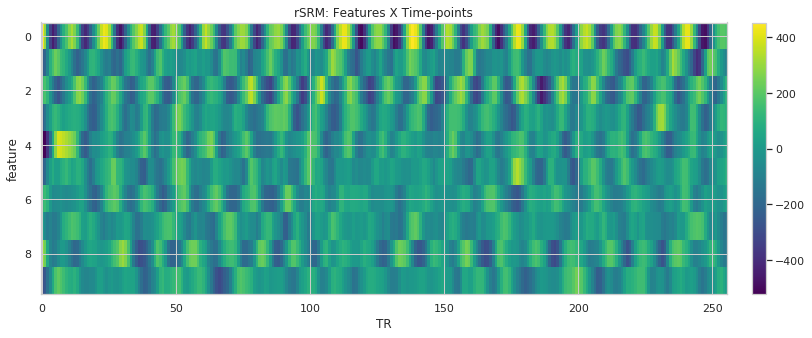

In [6]:
# plot shared responses as heatmaps

plt.figure(figsize=(15, 5))
plt.title('rSRM: Features X Time-points')
plt.xlabel('TR')
plt.ylabel('feature')
plt.imshow(srm.r_, cmap='viridis', aspect='auto')
plt.colorbar(orientation='vertical', pad=.03)  #fraction=0.03, 

In [7]:
 # calculate power spectrum of components
    
frequencies, powerdensities = [], []
for comp in range(len(srm.r_)):
    freq, power = periodogram(srm.r_[comp,:], fs=.5)
    frequencies.append(freq)
    powerdensities.append(power)
frequencies = np.array(frequencies)
powerdensities = np.array(powerdensities)

# Power densities and time courses of shared responses

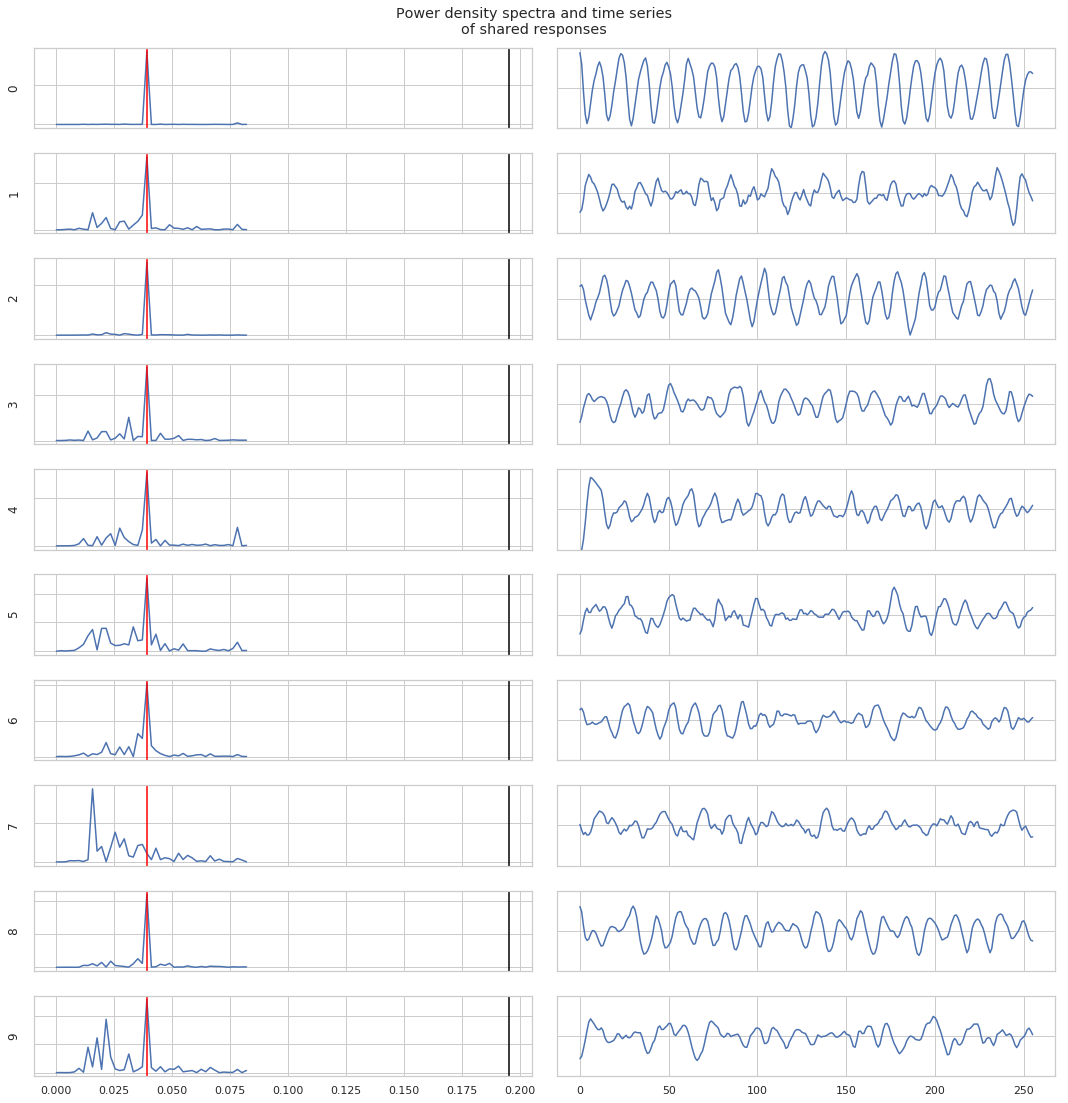

In [8]:
# only show lower half of frequency spectrum to avoid clutter
cut_to_length = int(len(powerdensities[0,:]) / 3)
rowheight = 1.5

fig, axs = plt.subplots(nrows=len(srm.r_), ncols=2, figsize=(15,len(srm.r_)*rowheight))
fig.suptitle('Power density spectra and time series\nof shared responses', y=1.02)

for comp_idx, axis in zip(range(len(srm.r_)), axs):
    # plot power densities
    sns.lineplot(y=powerdensities[comp_idx,:cut_to_length],
                 x=frequencies[comp_idx,:cut_to_length],
                 ax=axis[0])
    # mark stimulation frequency with red line
    axis[0].axvline(0.0390625, color='red')
    axis[0].axvline(0.1953125, color='black') 
    axis[0].set_ylabel('%i' % comp_idx)
    # plot time course
    sns.lineplot(y=srm.r_[comp_idx],
                 x=range(len(srm.r_[comp_idx])),
                 ax=axis[1],)
    axis[1].set_ylim(-500,500)  # give all time courses same y-limits

    for col in range(2):
        axis[col].set_yticklabels([])
        if comp_idx != len(srm.r_)-1:
            axis[col].set_xticklabels([])

    
plt.tight_layout()

# Trajectories (3D plots)

## Shared responses

Load srm data into pandas

In [9]:
# data frame containing shared responses (not individual subjects' data)
sr_df = pd.DataFrame(srm.r_.T)

In [10]:
# plot shared responses
geo = hyp.plot(sr_df, ndims=3, animate='parallel', size=[7,7], frame_rate=30, show=False,
              save_path='animations/traj_sr.mp4')
anim = geo.line_ani  # get animation attribute
HTML(anim.to_html5_video())  # convert to html video and show

/data/BnB_USER/oliver/somato/raw/venvs/somato_env/lib/python3.5/site-packages/hypertools/tools/df2mat.py:38: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  plot_data = df_num.as_matrix()


After a brief initial jump, the trajectory becomes a periodic (2d) "disk"

In [11]:
# as static plot
# geo = hyp.plot(sr_df, ndims=3, size=[7,7])

## Projected subjects' data

In [12]:
# load all subjects' data in array form
run1_data, run2_data, run1_masks, run2_masks = datagrabber()
run_arrs = load_data(run1_data, run2_data, run1_masks, run2_masks, whichrun=1)

loading data


In [13]:
# project all subjects into shared space
subjects_shared, subjects_individual = srm.transform(run_arrs)

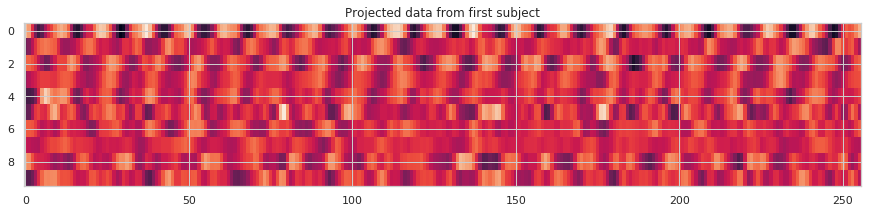

In [14]:
plt.figure(figsize=(15,15))
plt.title('Projected data from first subject')
plt.imshow(subjects_shared[0], aspect=5)

In [15]:
# load first subject's projected data into pandas
df_sub1 = pd.DataFrame(subjects_shared[0].T)

In [16]:
# plot trajectory animation
#geo = hyp.plot(df_sub1, ndims=3, animate='parallel', size=[7,7], frame_rate=30, show=False)
#anim = geo.line_ani  # get animation attribute
#HTML(anim.to_html5_video())  # convert to html video and show

In [17]:
# plot static trajectory
# geo = hyp.plot(df_sub1, ndims=3, size=[7,7], title="first subjects's trajectory" )

In [18]:
# create one giant data frame with all subject's shared data

# list of subject data frames
shared_dfs = []

for i in range(len(subjects_shared)):
    df = pd.DataFrame(subjects_shared[i].T)
    shared_dfs.append(df)
    
# aggregated dataframe
shared_df = pd.concat(shared_dfs)  # not really needed

In [19]:
# animation for all subjects

sns.set_context('talk')

geo = hyp.plot(shared_dfs,
               ndims=3,
               # figure handling
               show=False,
               title='projected data from all subjects',
               legend=[str(i) for i in range(len(subjects_shared))],
               size=[8,8],
               save_path='animations/traj_subs.mp4',
               # plotting options
               animate='parallel',
               frame_rate=15,
               tail_duration=1.,
               chemtrails=False,
               zoom=1.5)

anim = geo.line_ani
HTML(anim.to_html5_video())

/data/BnB_USER/oliver/somato/raw/venvs/somato_env/lib/python3.5/site-packages/hypertools/tools/df2mat.py:38: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  plot_data = df_num.as_matrix()


More plotting arguments for hyp.plot:

normalize, animate=('parallel', 'spin') (parallel creates moving lines), duration=30 (doesn't change anything for me),  tail_duration, rotations, zoom(float), chemtrails=True (trajectory behind), precog=True (trajectory ahead), framerate (default 50, 30: 8s ),

In [20]:
# animation for first n subjects

nsubs2plot = 3

geo = hyp.plot(shared_dfs[:nsubs2plot],
               ndims=3,
               # figure handling
               show=False,
               title='projected data from the first %i subjects' % nsubs2plot,
               size=[8,8],
               save_path='animations/traj_first%isubs.mp4' % nsubs2plot,
               # plotting options
               animate='parallel',
               frame_rate=15,
               tail_duration=1.,
               chemtrails=False,
               zoom=1.5)

anim = geo.line_ani
HTML(anim.to_html5_video())

/data/BnB_USER/oliver/somato/raw/venvs/somato_env/lib/python3.5/site-packages/hypertools/tools/df2mat.py:38: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  plot_data = df_num.as_matrix()


## Comparison with shuffled data (example data)

In [21]:
# shuffle subject1's df
df_sub1_shuff = df_sub1.sample(frac=1)
df_sub1_shuff.reset_index(inplace=True, drop=True)

/data/BnB_USER/oliver/somato/raw/venvs/somato_env/lib/python3.5/site-packages/hypertools/tools/df2mat.py:38: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  plot_data = df_num.as_matrix()


<Figure size 360x360 with 0 Axes>

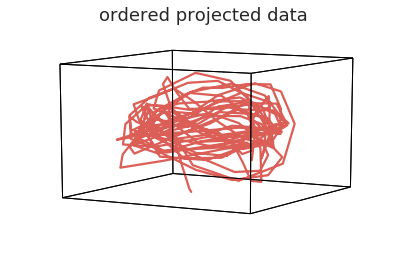

/data/BnB_USER/oliver/somato/raw/venvs/somato_env/lib/python3.5/site-packages/hypertools/tools/df2mat.py:38: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  plot_data = df_num.as_matrix()


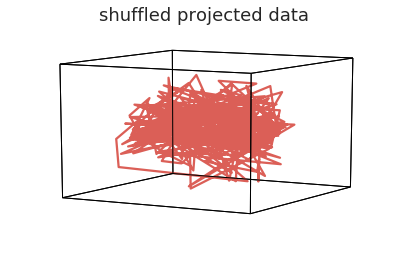

In [22]:
fig = plt.figure(figsize=(5,5))
axis1 = fig.add_subplot(projection='3d')
axis2 = fig.add_subplot(projection='3d')

geom1 = hyp.plot(df_sub1, ax=axis1, title='ordered projected data')
geom2 = hyp.plot(df_sub1_shuff, ax=axis2, title='shuffled projected data')